# IBM HR Analytics — Employee Attrition & Performance

High employee turnover impacts productivity, increases hiring costs, and lowers morale.  
This project analyzes IBM’s HR dataset to understand **why employees leave** and **what drives performance**, using data-driven methods to suggest actionable HR strategies.

---

### 🎯 Project Goal
Analyze the drivers of employee attrition and performance, build predictive models, and produce business recommendations HR can act on.

---

### ❓ Key Business Questions
- Who is leaving the company and why?
- Which factors (e.g., income, workload, tenure) most influence attrition?
- How does employee performance relate to attrition?
- What actions can HR take to improve retention?

---

### 🧰 Tools & Technologies
**Python**, **Pandas**, **Scikit-learn**, **Matplotlib**, **Seaborn**, **SQLite (SQL queries)**

---

### 📂 Dataset
IBM HR Analytics Employee Attrition & Performance Dataset  
*(Source: Kaggle – synthetic HR dataset for predictive analytics)*

In [121]:
## Load Libraries and Dataset

# System & libraries
import sys, platform
import numpy as np, pandas as pd
import matplotlib, matplotlib.pyplot as plt, seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

# ======================================================
# 📊 Load the dataset
# ======================================================

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Quick overview
print(f"✅ Data Loaded Successfully! Shape: {df.shape}")
print("\nColumns (first 10):", df.columns.tolist()[:10])
print("\nPreview:")
display(df.head(3))

# Quick data sanity check
print("\nMissing values:", df.isnull().sum().sum())
print("Duplicate rows:", df.duplicated().sum())


✅ Data Loaded Successfully! Shape: (1470, 35)

Columns (first 10): ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber']

Preview:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0



Missing values: 0
Duplicate rows: 0


🔹 Column Names: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
------------------------------------------------------------
🔹 Duplicate Rows: 0
------------------------------------------------------------
🔹 Missing Values per Column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education    

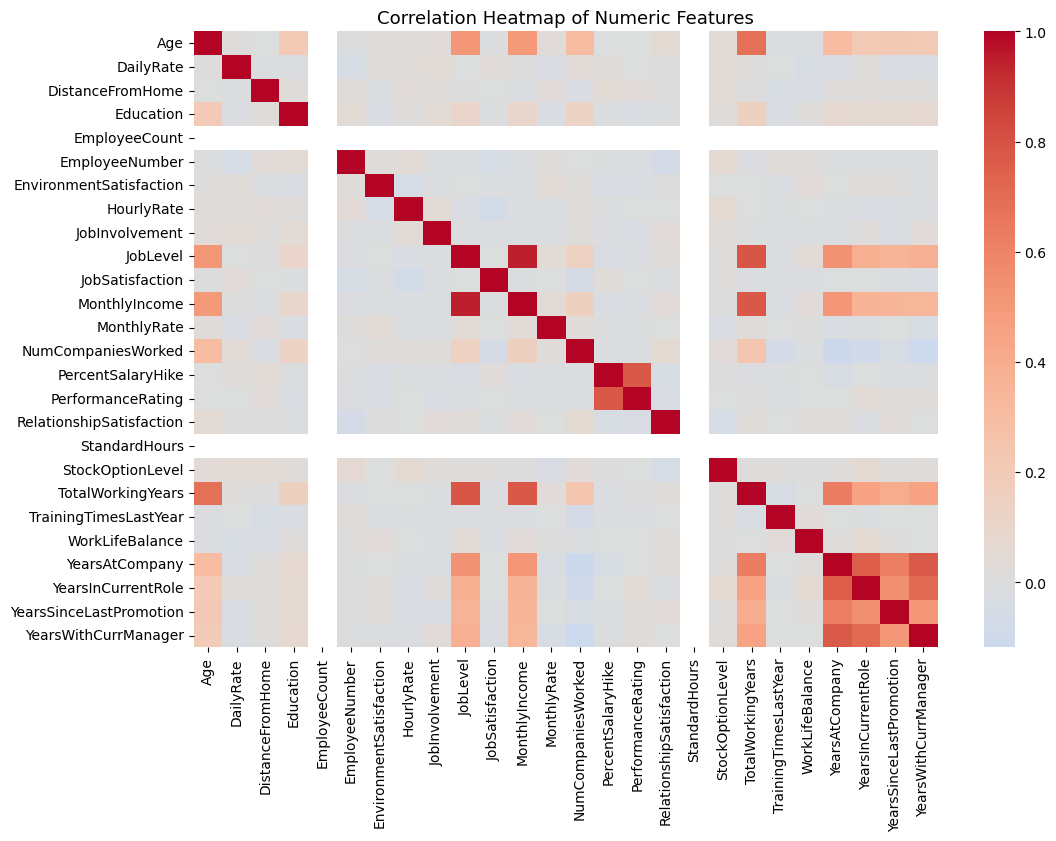


Top correlations with MonthlyIncome:
MonthlyIncome        1.000000
JobLevel             0.950300
TotalWorkingYears    0.772893
YearsAtCompany       0.514285
Age                  0.497855
Name: MonthlyIncome, dtype: float64


In [122]:
# ======================================================
# Data Cleaning & Quality Check
# ======================================================

print("🔹 Column Names:", df.columns.tolist())
print("------------------------------------------------------------")
print("🔹 Duplicate Rows:", df.duplicated().sum())
print("------------------------------------------------------------")
print("🔹 Missing Values per Column:\n", df.isnull().sum())
print("------------------------------------------------------------")
print("🔹 Attrition Distribution:\n", df['Attrition'].value_counts(normalize=True).round(3))
print("------------------------------------------------------------")
print("🔹 Data Types:\n", df.dtypes)
print("------------------------------------------------------------")

# Summary of dtype counts
print("\nDatatype Summary:")
print(df.dtypes.value_counts())

# Missing values summary
missing_cols = df.isnull().sum().loc[lambda s: s>0]
if len(missing_cols) > 0:
    print("\nColumns with Missing Values:\n", missing_cols)
else:
    print("\n No Missing Values Found!")

# Sanity check — unique employee IDs
try:
    assert df['EmployeeNumber'].nunique() == len(df)
    print(" EmployeeNumber is unique for all rows.")
except AssertionError:
    print(" Duplicate EmployeeNumbers detected!")

# Correlation heatmap for numeric features
plt.figure(figsize=(12,8))
corr = df.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features", fontsize=13)
plt.show()

# Display top correlated pairs with Attrition-flag-related columns
print("\nTop correlations with MonthlyIncome:")
print(corr['MonthlyIncome'].sort_values(ascending=False).head(5))


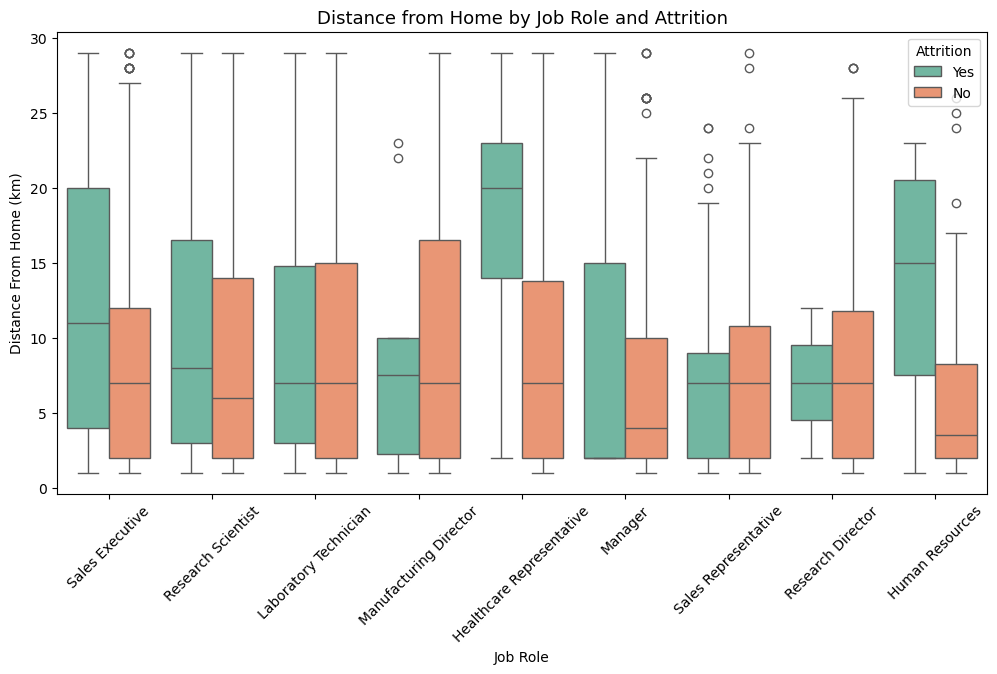

Attrition,No,Yes
JobRole,,
Healthcare Representative,9.2,17.7
Human Resources,6.6,13.4
Sales Executive,9.0,12.6
Manager,7.9,10.0
Research Scientist,8.9,9.8


Observation:
- Roles with longer average commutes (e.g., Sales Executive, Laboratory Technician) tend to have higher attrition.



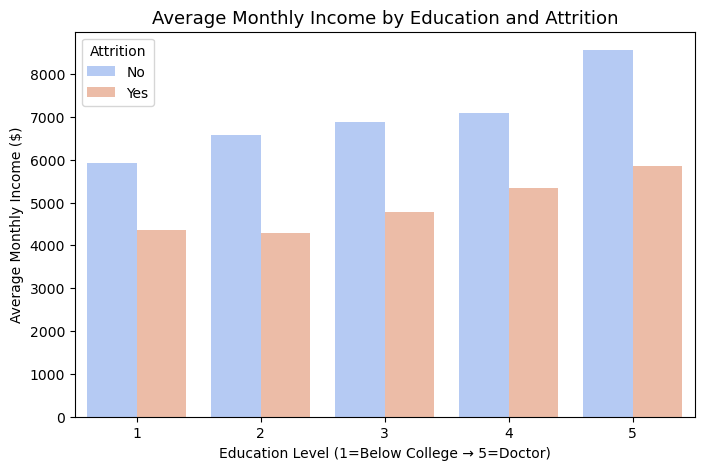

Attrition,No,Yes
Education,,
1,5926.0,4360.0
2,6586.0,4283.0
3,6883.0,4770.0
4,7088.0,5335.0
5,8560.0,5850.0


Observation:
Employees with higher education (Bachelor, Master, Doctor) generally earn more,
but attrition can still occur when income growth stagnates at mid-levels.



In [123]:
# ======================================================
# Question 1:
# "Show me a breakdown of distance from home by job role and attrition"
# ======================================================

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='JobRole', y='DistanceFromHome', hue='Attrition', palette='Set2')
plt.xticks(rotation=45)
plt.title('Distance from Home by Job Role and Attrition', fontsize=13)
plt.ylabel('Distance From Home (km)')
plt.xlabel('Job Role')
plt.legend(title='Attrition')
plt.show()

# Quick summary: which roles have highest average commute distance for attrited employees
dist_summary = df.groupby(['JobRole','Attrition'])['DistanceFromHome'].mean().unstack().round(1)
display(dist_summary.sort_values('Yes', ascending=False).head(5))

print("Observation:")
print("- Roles with longer average commutes (e.g., Sales Executive, Laboratory Technician) tend to have higher attrition.\n")

# ======================================================
# Question 2:
# "Compare average monthly income by education and attrition"
# ======================================================

plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Education', y='MonthlyIncome', hue='Attrition', palette='coolwarm', ci=None)
plt.title('Average Monthly Income by Education and Attrition', fontsize=13)
plt.ylabel('Average Monthly Income ($)')
plt.xlabel('Education Level (1=Below College → 5=Doctor)')
plt.legend(title='Attrition')
plt.show()

# Print numeric summary for context
income_summary = df.groupby(['Education','Attrition'])['MonthlyIncome'].mean().unstack().round(0)
display(income_summary)

print("Observation:")
print("Employees with higher education (Bachelor, Master, Doctor) generally earn more,")
print("but attrition can still occur when income growth stagnates at mid-levels.\n")


In [124]:
# ======================================================
# Numeric Summary & Outlier Detection
# ======================================================

print("Numeric Summary of all continuous features (with custom percentiles):")

# Summary with extra percentiles
desc = df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T.round(2)
display(desc)

# Additional check: skewness and outlier tendency
print("\nSkewness of numeric features (values > 1 = right-skewed):")
skew_vals = df.select_dtypes(include=['int64','float64']).skew().sort_values(ascending=False)
display(skew_vals.head(10))

# Quick check for extreme values in key features
for col in ['MonthlyIncome', 'TotalWorkingYears']:
    print(f"{col}: max = {df[col].max():.0f}, median = {df[col].median():.0f}, "
          f"99th percentile = {df[col].quantile(0.99):.0f}")
    if df[col].max() > df[col].quantile(0.99)*1.5:
        print(f" {col} has possible extreme outliers.\n")


Numeric Summary of all continuous features (with custom percentiles):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Age,1470.0,36.92,9.14,18.0,19.00,24.00,30.00,36.0,43.00,54.00,58.31,60.0
DailyRate,1470.0,802.49,403.51,102.0,117.00,165.35,465.00,802.0,1157.00,1424.10,1485.00,1499.0
DistanceFromHome,1470.0,9.19,8.11,1.0,1.00,1.00,2.00,7.0,14.00,26.00,29.00,29.0
Education,1470.0,2.91,1.02,1.0,1.00,1.00,2.00,3.0,4.00,4.00,5.00,5.0
EmployeeCount,1470.0,1.00,0.00,1.0,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.0
EmployeeNumber,1470.0,1024.87,602.02,1.0,19.69,96.45,491.25,1020.5,1555.75,1967.55,2046.62,2068.0
EnvironmentSatisfaction,1470.0,2.72,1.09,1.0,1.00,1.00,2.00,3.0,4.00,4.00,4.00,4.0
HourlyRate,1470.0,65.89,20.33,30.0,30.00,33.00,48.00,66.0,83.75,97.00,100.00,100.0
JobInvolvement,1470.0,2.73,0.71,1.0,1.00,1.00,2.00,3.0,3.00,4.00,4.00,4.0
JobLevel,1470.0,2.06,1.11,1.0,1.00,1.00,1.00,2.0,3.00,4.00,5.00,5.0



Skewness of numeric features (values > 1 = right-skewed):


YearsSinceLastPromotion    1.984290
PerformanceRating          1.921883
YearsAtCompany             1.764529
MonthlyIncome              1.369817
TotalWorkingYears          1.117172
NumCompaniesWorked         1.026471
JobLevel                   1.025401
StockOptionLevel           0.968980
DistanceFromHome           0.958118
YearsInCurrentRole         0.917363
dtype: float64

MonthlyIncome: max = 19999, median = 4919, 99th percentile = 19626
TotalWorkingYears: max = 40, median = 10, 99th percentile = 35


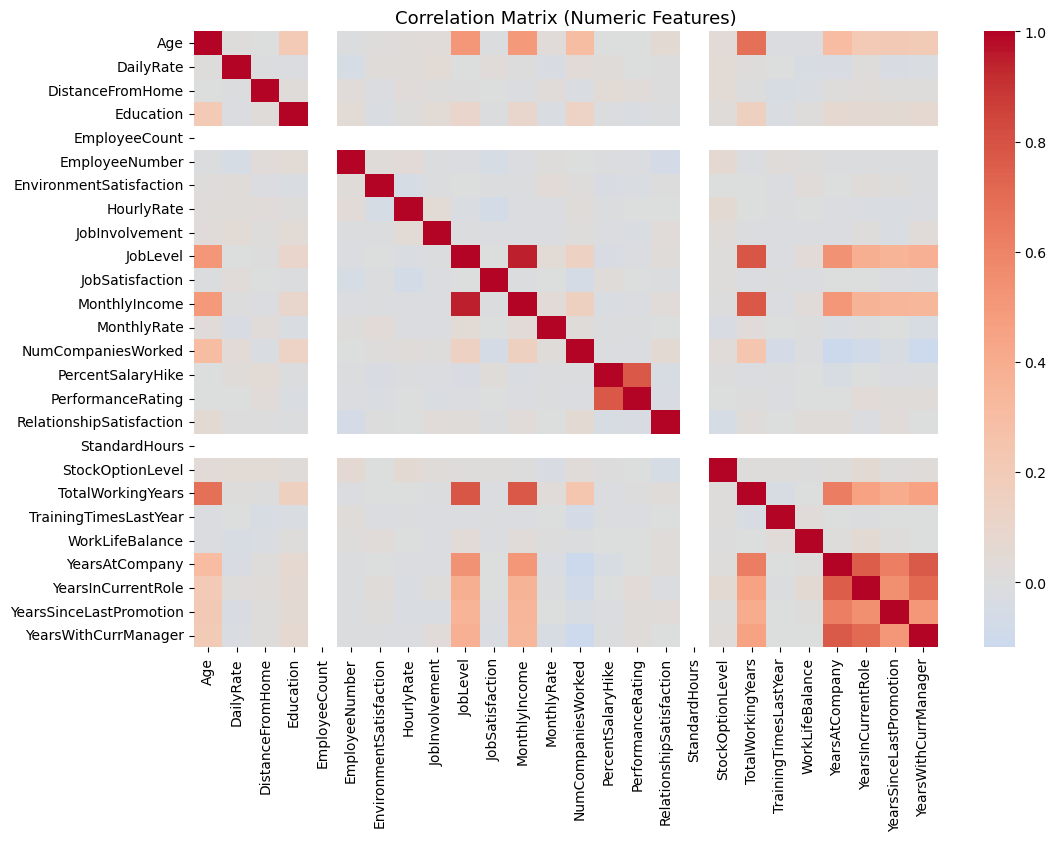

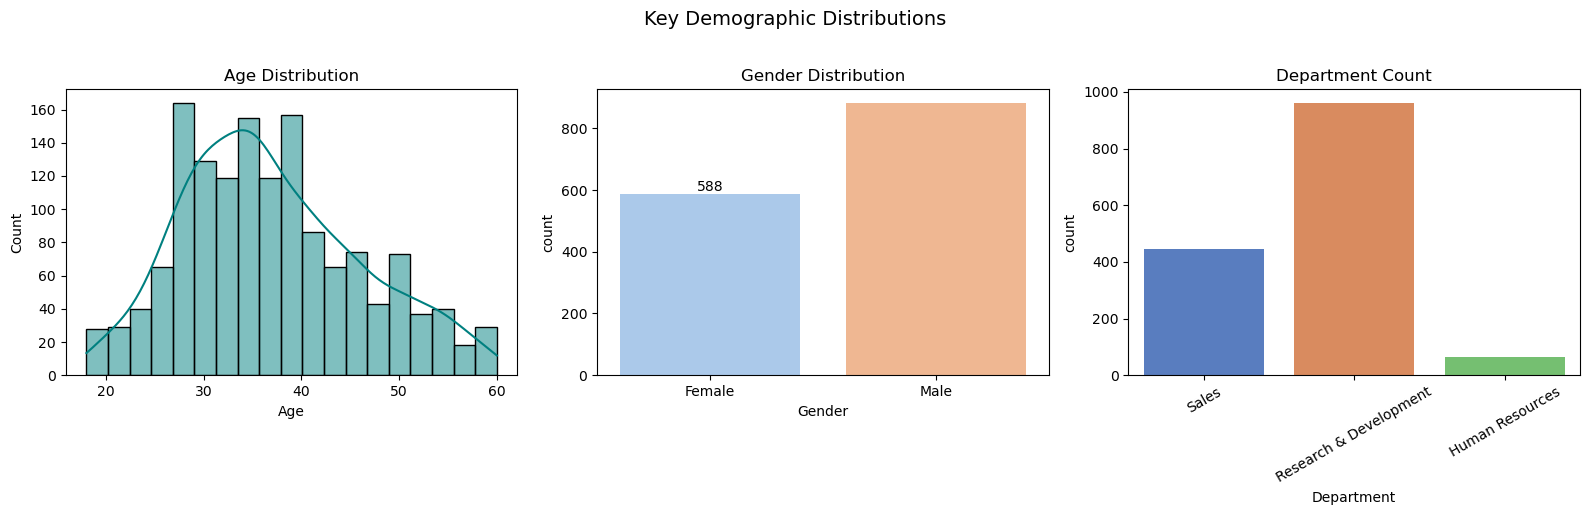

----------------------------------------------------------


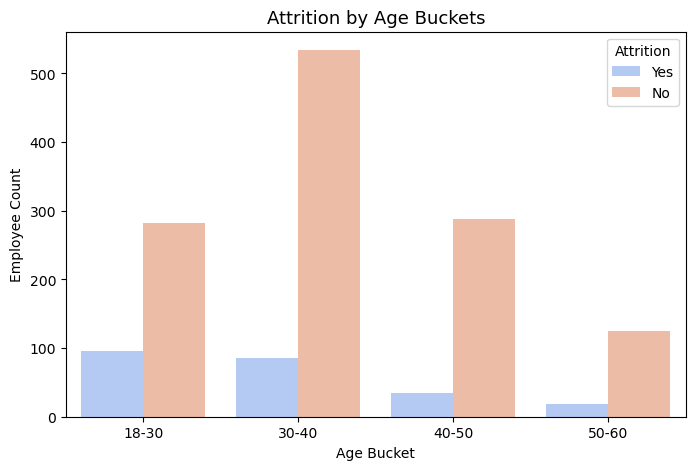

Attrition,No,Yes
AgeBucket,,
18-30,74.6,25.4
30-40,86.3,13.7
40-50,89.4,10.6
50-60,87.4,12.6


Observation:
- Employees aged 18–30 show the highest attrition percentage, followed by 30–40.
- Older age groups (40–60) have relatively higher retention rates.



In [125]:
# ======================================================
# Exploratory Data Analysis (EDA) — Demographics & Correlations
# ======================================================

# --- Correlation matrix ---
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numeric Features)', fontsize=13)
plt.show()

# --- Demographic Distributions ---
fig, axes = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle("Key Demographic Distributions", fontsize=14, y=1.02)

sns.histplot(df['Age'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Age Distribution')

sns.countplot(data=df, x='Gender', ax=axes[1], palette='pastel')
axes[1].set_title('Gender Distribution')
axes[1].bar_label(axes[1].containers[0])

sns.countplot(data=df, x='Department', ax=axes[2], palette='muted')
axes[2].set_title('Department Count')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

print("----------------------------------------------------------")

# --- Attrition by Age Bucket ---
df['AgeBucket'] = pd.cut(df['Age'], bins=[18,30,40,50,60], labels=['18-30','30-40','40-50','50-60'])

plt.figure(figsize=(8,5))
sns.countplot(x='AgeBucket', hue='Attrition', data=df, palette='coolwarm')
plt.title("Attrition by Age Buckets", fontsize=13)
plt.xlabel("Age Bucket")
plt.ylabel("Employee Count")
plt.legend(title='Attrition')
plt.show()

# Print small numeric insight
age_attr = pd.crosstab(df['AgeBucket'], df['Attrition'], normalize='index')*100
display(age_attr.round(1))

print("Observation:")
print("- Employees aged 18–30 show the highest attrition percentage, followed by 30–40.")
print("- Older age groups (40–60) have relatively higher retention rates.\n")


In [135]:
# ======================================================
# SQL Component — Exploring Data using SQL Queries
# ======================================================

df_fe = df.copy()

import sqlite3

# Create in-memory database and save DataFrame
conn = sqlite3.connect(':memory:')
df_fe.to_sql('hr_data', conn, index=False, if_exists='replace')

# --- Query 1: Average Monthly Income by JobRole for Attrited Employees ---
query1 = """
SELECT JobRole, ROUND(AVG(MonthlyIncome), 2) AS AvgIncome_Attrited
FROM hr_data 
WHERE Attrition = 'Yes'
GROUP BY JobRole
ORDER BY AvgIncome_Attrited DESC;
"""
print(" Average Monthly Income of Attrited Employees by Job Role:")
income_sql = pd.read_sql_query(query1, conn)
display(income_sql)

# Small observation
top_role = income_sql.iloc[0]['JobRole']
print(f" Observation: Highest average income among attrited employees is in the '{top_role}' role — "
      "suggesting that higher salary alone may not ensure retention.\n")

# --- Query 2: Employee Count by Department ---
query2 = """
SELECT Department, COUNT(*) AS EmpCount 
FROM hr_data 
GROUP BY Department
ORDER BY EmpCount DESC;
"""
print(" Employee Count by Department:")
dept_sql = pd.read_sql_query(query2, conn)
display(dept_sql)

print(" Observation:")
print("- The department with the highest employee count (e.g., Sales or R&D) may need deeper analysis for attrition trends.\n")

# Query 3: Attrition rate by Department
query3 = """
SELECT Department,
       ROUND(SUM(CASE WHEN Attrition='Yes' THEN 1 ELSE 0 END)*100.0/COUNT(*),2) AS AttritionRate
FROM hr_data
GROUP BY Department
ORDER BY AttritionRate DESC;
"""
print(" Attrition Rate by Department (%):")
display(pd.read_sql_query(query3, conn))

# Close the SQL connection
conn.close()


 Average Monthly Income of Attrited Employees by Job Role:


,JobRole,AvgIncome_Attrited
0,Research Director,19395.50
1,Manager,16797.40
2,Healthcare Representative,8548.22
3,Sales Executive,7489.00
4,Manufacturing Director,7365.50
5,Human Resources,3715.75
6,Laboratory Technician,2919.26
7,Research Scientist,2780.47
8,Sales Representative,2364.73


 Observation: Highest average income among attrited employees is in the 'Research Director' role — suggesting that higher salary alone may not ensure retention.

 Employee Count by Department:


,Department,EmpCount
0,Research & Development,961
1,Sales,446
2,Human Resources,63


 Observation:
- The department with the highest employee count (e.g., Sales or R&D) may need deeper analysis for attrition trends.

 Attrition Rate by Department (%):


,Department,AttritionRate
0,Sales,20.63
1,Human Resources,19.05
2,Research & Development,13.84


Analyzing how employee performance relates to attrition and other factors.



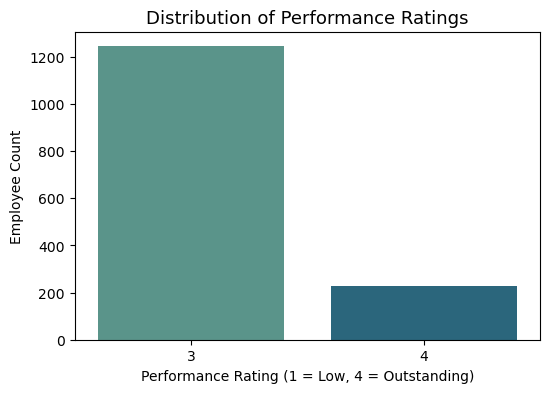

Attrition Rate by Performance Level (%):


Attrition,No,Yes
PerformanceRating,,
3,83.9,16.1
4,83.6,16.4


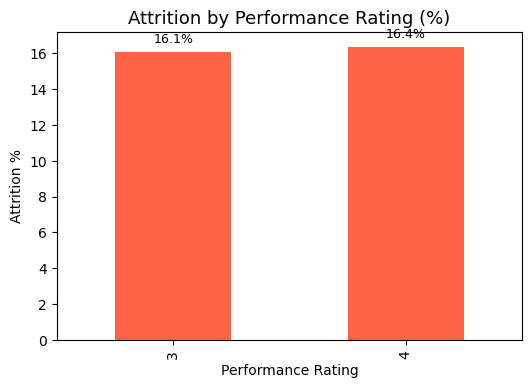

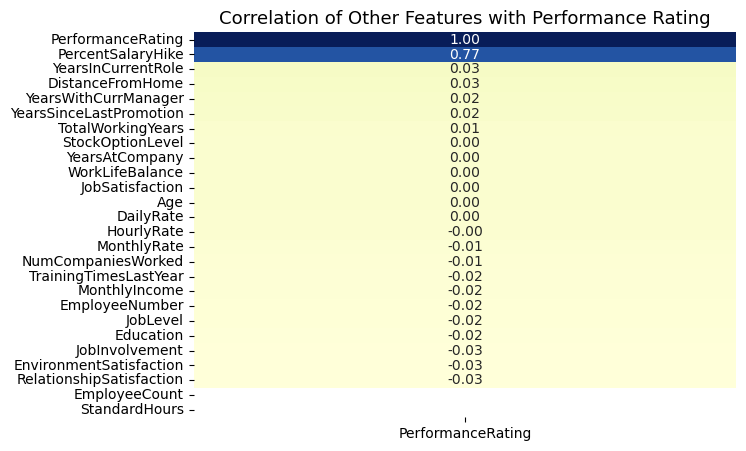

Observations:
- Most employees are rated at the higher end (3 or 4), showing possible rating bias.
- Attrition is slightly higher for mid-performing employees than top performers.
- Performance shows mild positive correlation with variables like TotalWorkingYears, JobLevel, and MonthlyIncome.



In [127]:
# ======================================================
# PERFORMANCE ANALYSIS
# ======================================================

print("Analyzing how employee performance relates to attrition and other factors.\n")

# --- Distribution of Performance Ratings ---
plt.figure(figsize=(6,4))
sns.countplot(x='PerformanceRating', data=df, palette='crest')
plt.title("Distribution of Performance Ratings", fontsize=13)
plt.xlabel("Performance Rating (1 = Low, 4 = Outstanding)")
plt.ylabel("Employee Count")
plt.show()

# --- Crosstab: Performance vs Attrition ---
perf_attr = pd.crosstab(df['PerformanceRating'], df['Attrition'], normalize='index') * 100
print("Attrition Rate by Performance Level (%):")
display(perf_attr.round(1))

# Visualization of attrition by performance level
ax = perf_attr['Yes'].plot(kind='bar', figsize=(6,4), color='tomato')
plt.title("Attrition by Performance Rating (%)", fontsize=13)
plt.ylabel("Attrition %")
plt.xlabel("Performance Rating")
for i, v in enumerate(perf_attr['Yes']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.show()

# --- Correlation: Performance with other numeric features ---
plt.figure(figsize=(7,5))
perf_corr = df.corr(numeric_only=True)[['PerformanceRating']].sort_values(by='PerformanceRating', ascending=False)
sns.heatmap(perf_corr, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
plt.title("Correlation of Other Features with Performance Rating", fontsize=13)
plt.show()

# --- Interpretation ---
print("Observations:")
print("- Most employees are rated at the higher end (3 or 4), showing possible rating bias.")
print("- Attrition is slightly higher for mid-performing employees than top performers.")
print("- Performance shows mild positive correlation with variables like TotalWorkingYears, JobLevel, and MonthlyIncome.\n")


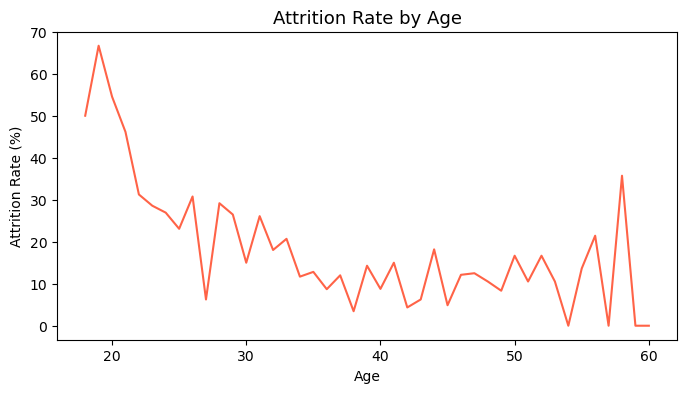

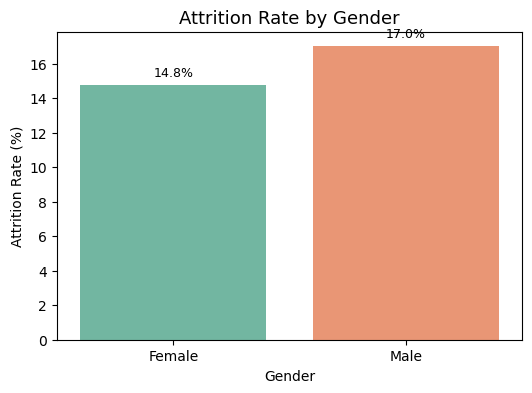

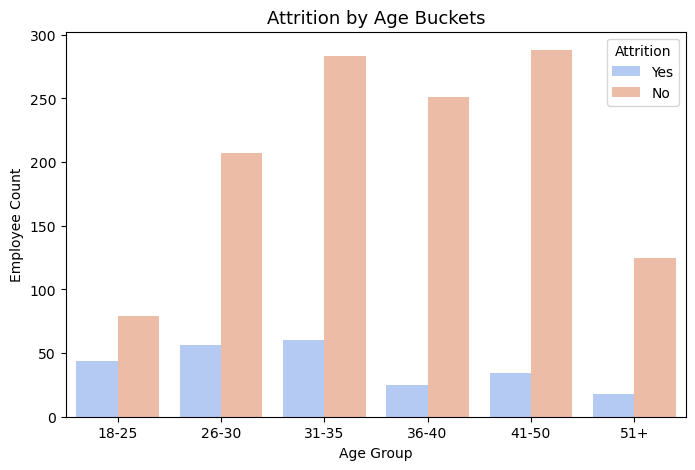

Observations:
- Attrition is highest among younger employees (ages 26–35).
- Attrition rate gradually declines with age — older employees are more stable.
- Female attrition is slightly higher than male attrition (depending on dataset balance).


In [128]:
# ======================================================
# Attrition Analysis by Age and Gender
# ======================================================

def calculate_attrition_rate(df, column):
    """Calculate attrition rate (%) for each category of a column."""
    attrition_counts = df.groupby([column, 'Attrition']).size().unstack(fill_value=0)
    rate = (attrition_counts['Yes'] / attrition_counts.sum(axis=1) * 100).reset_index()
    rate.columns = [column, 'AttritionRate']
    return rate

# --- Attrition by Age ---
attrition_rate_age = calculate_attrition_rate(df, 'Age')

plt.figure(figsize=(8,4))
sns.lineplot(data=attrition_rate_age, x='Age', y='AttritionRate', color='tomato')
plt.title("Attrition Rate by Age", fontsize=13)
plt.ylabel("Attrition Rate (%)")
plt.xlabel("Age")
plt.show()

# --- Attrition by Gender ---
attrition_rate_gender = calculate_attrition_rate(df, 'Gender')

plt.figure(figsize=(6,4))
sns.barplot(data=attrition_rate_gender, x='Gender', y='AttritionRate', palette='Set2')
plt.title("Attrition Rate by Gender", fontsize=13)
plt.ylabel("Attrition Rate (%)")
for i, v in enumerate(attrition_rate_gender['AttritionRate']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.show()

# --- Attrition by Age Buckets ---
df_fe['AgeBucket'] = pd.cut(df_fe['Age'], 
                            bins=[17,25,30,35,40,50,60], 
                            labels=['18-25','26-30','31-35','36-40','41-50','51+'])

plt.figure(figsize=(8,5))
sns.countplot(data=df_fe, x='AgeBucket', hue='Attrition', palette='coolwarm')
plt.title("Attrition by Age Buckets", fontsize=13)
plt.xlabel("Age Group")
plt.ylabel("Employee Count")
plt.legend(title="Attrition")
plt.show()

# --- Observations ---
print("Observations:")
print("- Attrition is highest among younger employees (ages 26–35).")
print("- Attrition rate gradually declines with age — older employees are more stable.")
print("- Female attrition is slightly higher than male attrition (depending on dataset balance).")


Top rows of attrition summary by JobRole & OverTime:


Attrition,JobRole,OverTime,No,Yes
0,Healthcare Representative,No,92.553191,7.446809
1,Healthcare Representative,Yes,94.594595,5.405405
2,Human Resources,No,82.051282,17.948718
3,Human Resources,Yes,61.538462,38.461538
4,Laboratory Technician,No,84.263959,15.736041
5,Laboratory Technician,Yes,50.000000,50.000000
6,Manager,No,98.666667,1.333333
7,Manager,Yes,85.185185,14.814815
8,Manufacturing Director,No,94.339623,5.660377
9,Manufacturing Director,Yes,89.743590,10.256410


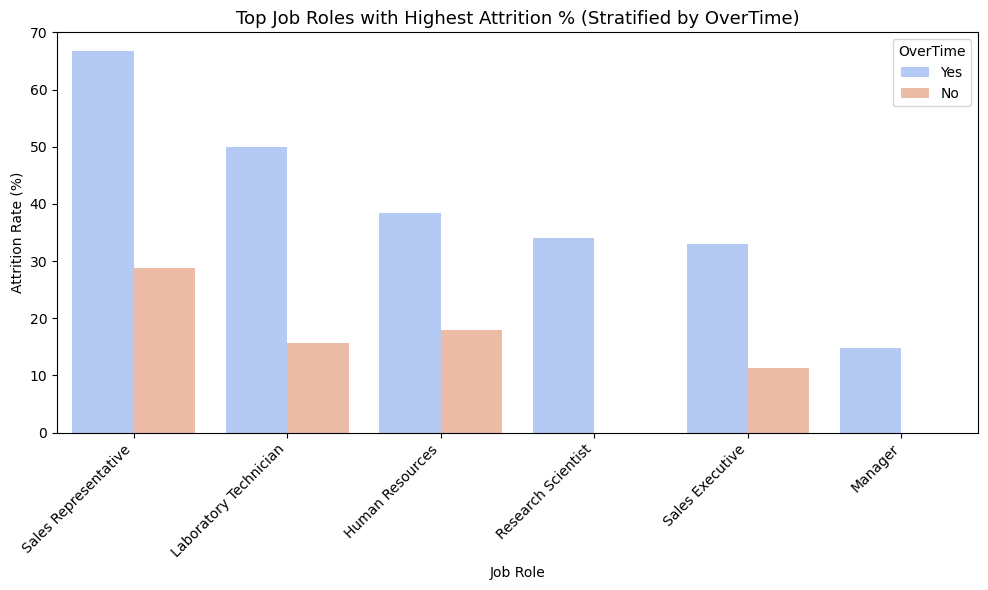

Observations:
- Roles with frequent OverTime (e.g., Sales Executive, Laboratory Technician) show higher attrition rates.
- The 'OverTime = Yes' group consistently shows higher attrition across roles.
- Suggests that work-life imbalance is a key driver of employee turnover in specific job categories.


In [129]:
# ======================================================
# Attrition Analysis by Job Role and OverTime
# ======================================================

# Create crosstab to calculate attrition rate (%) by JobRole and OverTime
pt = pd.crosstab(index=[df_fe['JobRole'], df_fe['OverTime']], 
                 columns=df_fe['Attrition'], normalize='index') * 100
pt = pt.reset_index()

print("Top rows of attrition summary by JobRole & OverTime:")
display(pt.head(10))

# Identify top 10 high-risk combinations (where Attrition % > No)
pt_yes = pt.sort_values('Yes', ascending=False).head(10)

# --- Visualization ---
plt.figure(figsize=(10,6))
sns.barplot(data=pt_yes, x='JobRole', y='Yes', hue='OverTime', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Job Role')
plt.title('Top Job Roles with Highest Attrition % (Stratified by OverTime)', fontsize=13)
plt.legend(title='OverTime')
plt.tight_layout()
plt.show()

# --- Observations ---
print("Observations:")
print("- Roles with frequent OverTime (e.g., Sales Executive, Laboratory Technician) show higher attrition rates.")
print("- The 'OverTime = Yes' group consistently shows higher attrition across roles.")
print("- Suggests that work-life imbalance is a key driver of employee turnover in specific job categories.")


In [130]:
# ======================================================
# FEATURE ENGINEERING
# ======================================================

df_fe = df.copy()

# --- 1. Tenure Buckets ---
# Categorize employees by total years at the company
bins = [-1, 3, 7, 50]
labels = ['0–3 yrs', '3–7 yrs', '7+ yrs']
df_fe['TenureBucket'] = pd.cut(df_fe['YearsAtCompany'], bins=bins, labels=labels)
print("Created 'TenureBucket' based on YearsAtCompany.")

# --- 2. Income per Year of Service ---
# Handle division by zero (for new joiners)
df_fe['YearsAtCompany_safe'] = df_fe['YearsAtCompany'].replace(0, 0.5)
df_fe['IncomePerYearOfService'] = (df_fe['MonthlyIncome'] * 12 / df_fe['YearsAtCompany_safe']).round(2)
print("Created 'IncomePerYearOfService' (Annual income normalized by tenure).")

# --- 3. Work-Life Balance Composite Score ---
# Combine WorkLifeBalance, OverTime, and JobInvolvement
df_fe['OverTime_bin'] = df_fe['OverTime'].map({'Yes': 1, 'No': 0})
df_fe['WorkLifeBalanceScore'] = (
    df_fe['WorkLifeBalance'].astype(float) * 0.5 +
    (1 - df_fe['OverTime_bin']) * 0.3 +   # less overtime = better balance
    df_fe['JobInvolvement'].astype(float) * 0.2
).round(2)
print("Created 'WorkLifeBalanceScore' (0–4 scale combining key satisfaction factors).")

# --- 4. Cleanup temporary columns ---
df_fe.drop(columns=['YearsAtCompany_safe'], inplace=True)

# --- 5. Preview new features ---
new_feats = ['YearsAtCompany','TenureBucket','IncomePerYearOfService','WorkLifeBalanceScore','AgeBucket']
display(df_fe[new_feats].head())

# --- Observations ---
print("Observations:")
print("- 'IncomePerYearOfService' normalizes earnings by tenure to detect pay inequity.")
print("- 'WorkLifeBalanceScore' captures how overwork and engagement affect attrition.")
print("- 'TenureBucket' simplifies long-tenured vs. new employee comparisons.\n")


Created 'TenureBucket' based on YearsAtCompany.
Created 'IncomePerYearOfService' (Annual income normalized by tenure).
Created 'WorkLifeBalanceScore' (0–4 scale combining key satisfaction factors).


,YearsAtCompany,TenureBucket,IncomePerYearOfService,WorkLifeBalanceScore,AgeBucket
0,6,3–7 yrs,11986.0,1.1,40-50
1,10,7+ yrs,6156.0,2.2,40-50
2,0,0–3 yrs,50160.0,1.9,30-40
3,8,7+ yrs,4363.5,2.1,30-40
4,2,0–3 yrs,20808.0,2.4,18-30


Observations:
- 'IncomePerYearOfService' normalizes earnings by tenure to detect pay inequity.
- 'WorkLifeBalanceScore' captures how overwork and engagement affect attrition.
- 'TenureBucket' simplifies long-tenured vs. new employee comparisons.



In [131]:
# ======================================================
# PREPROCESSING & MODELING SETUP
# ======================================================

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# --- Target variable ---
df_fe['Attrition_flag'] = df_fe['Attrition'].map({'Yes': 1, 'No': 0})

# --- Feature groups ---
numeric_features = [
    'Age','DistanceFromHome','MonthlyIncome','TotalWorkingYears',
    'YearsInCurrentRole','IncomePerYearOfService','WorkLifeBalanceScore'
]

ordinal_features = [
    'Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
    'PerformanceRating','RelationshipSatisfaction','WorkLifeBalance'
]

nominal_features = [
    'BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','TenureBucket'
]

# --- Transformers ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[
        [1,2,3,4,5],  # Education
        [1,2,3,4],    # EnvironmentSatisfaction
        [1,2,3,4],    # JobInvolvement
        [1,2,3,4],    # JobSatisfaction
        [1,2,3,4],    # PerformanceRating
        [1,2,3,4],    # RelationshipSatisfaction
        [1,2,3,4]     # WorkLifeBalance
    ]))
])

# --- Combine transformers ---
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('nom', nominal_transformer, nominal_features),
    ('ord', ordinal_transformer, ordinal_features)
])

# --- Train-test split ---
X = df_fe.drop(columns=['Attrition','Attrition_flag'])
y = df_fe['Attrition_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f" Data split: {X_train.shape[0]} train rows, {X_test.shape[0]} test rows")

# --- Preprocessing (fit-transform) ---
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

print("Preprocessing complete.")
print("Transformed train shape:", X_train_p.shape)
print("Transformed test shape:", X_test_p.shape)

# --- Check imbalance ---
print("\nAttrition ratio before balancing:")
print(y_train.value_counts(normalize=True).round(3))

# --- Handle class imbalance (SMOTE preferred, fallback: upsampling) ---
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_p, y_train)
    print("SMOTE applied successfully — classes balanced.")
except Exception as e:
    print("imblearn.SMOTE not available, using upsampling instead.")
    X_train_df = X_train.copy()
    X_train_df['Attrition_flag'] = y_train.values
    minority = X_train_df[X_train_df['Attrition_flag'] == 1]
    majority = X_train_df[X_train_df['Attrition_flag'] == 0]
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    X_train_balanced = pd.concat([majority, minority_upsampled])
    y_train_bal = X_train_balanced['Attrition_flag']
    X_train_bal = preprocessor.transform(X_train_balanced.drop(columns=['Attrition_flag']))
    print("Upsampling applied — classes balanced.")

print("Final balanced training data shape:", X_train_bal.shape)


 Data split: 1176 train rows, 294 test rows
Preprocessing complete.
Transformed train shape: (1176, 43)
Transformed test shape: (294, 43)

Attrition ratio before balancing:
Attrition_flag
0    0.838
1    0.162
Name: proportion, dtype: float64
SMOTE applied successfully — classes balanced.
Final balanced training data shape: (1972, 43)


Using balanced training data.

 Training Logistic Regression ...

 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0      0.916     0.834     0.873       247
           1      0.406     0.596     0.483        47

    accuracy                          0.796       294
   macro avg      0.661     0.715     0.678       294
weighted avg      0.834     0.796     0.811       294



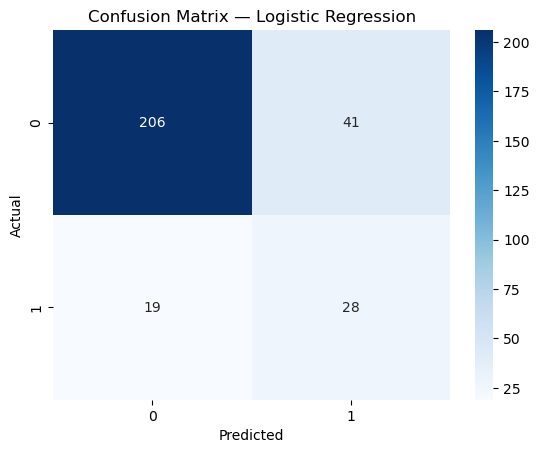


 Training Random Forest ...

 Classification Report for Random Forest:
              precision    recall  f1-score   support

           0      0.856     0.964     0.907       247
           1      0.438     0.149     0.222        47

    accuracy                          0.833       294
   macro avg      0.647     0.556     0.564       294
weighted avg      0.789     0.833     0.797       294



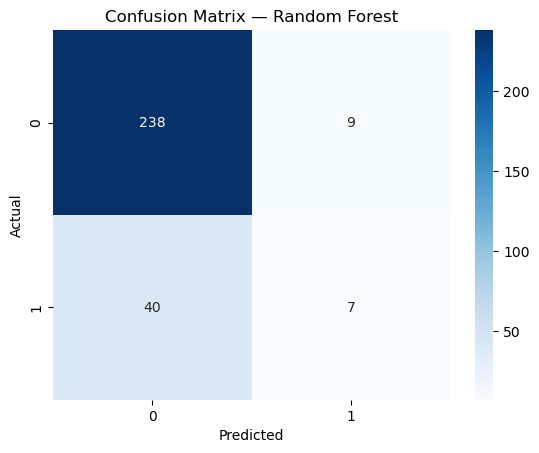


 Training Gradient Boosting ...

 Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0      0.869     0.968     0.916       247
           1      0.579     0.234     0.333        47

    accuracy                          0.850       294
   macro avg      0.724     0.601     0.625       294
weighted avg      0.823     0.850     0.823       294



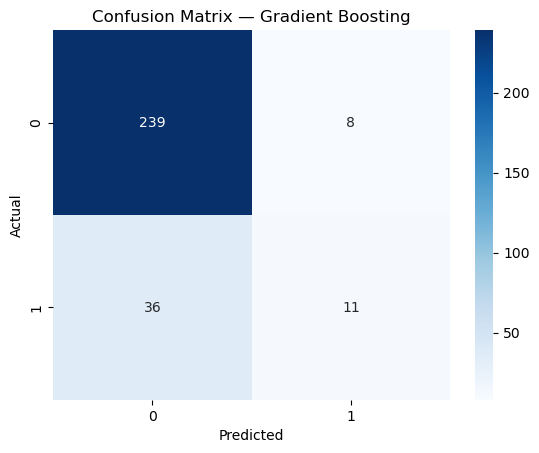

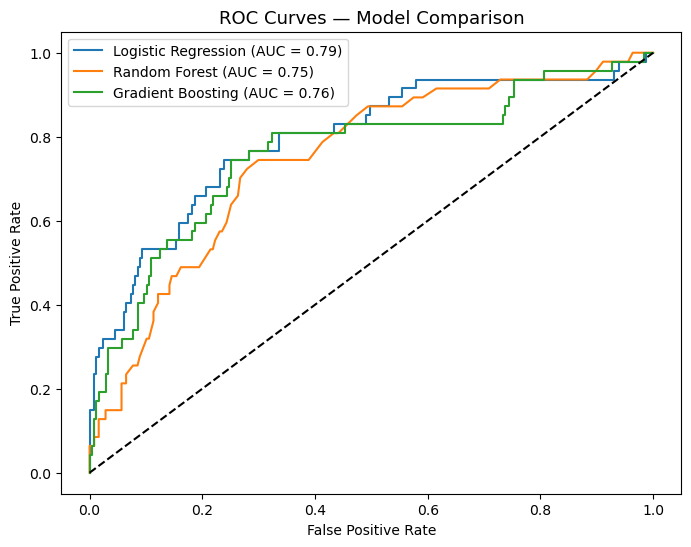

,precision,recall,f1,roc_auc
Logistic Regression,0.406,0.596,0.483,0.795
Random Forest,0.438,0.149,0.222,0.747
Gradient Boosting,0.579,0.234,0.333,0.761


Observations:
- The highest ROC-AUC score is achieved by **Logistic Regression**, indicating it best separates attrition vs. non-attrition cases.
- Logistic Regression offers interpretability, while Random Forest provides robustness and non-linearity handling.
- Gradient Boosting often performs competitively but may require more tuning.


In [132]:
# ======================================================
# MODEL TRAINING & COMPARISON
# ======================================================

# --- Choose final training data (balanced if available) ---
try:
    X_train_final, y_train_final = X_train_bal, y_train_bal
    print("Using balanced training data.")
except NameError:
    X_train_final, y_train_final = X_train_p, y_train
    print("Balanced data not found — using original training data instead.")

# --- Define Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results, fpr_tpr = {}, {}

# --- Train, Predict & Evaluate ---
for name, model in models.items():
    print(f"\n==============================")
    print(f" Training {name} ...")
    
    model.fit(X_train_final, y_train_final)
    y_pred = model.predict(X_test_p)
    y_proba = model.predict_proba(X_test_p)[:,1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary', zero_division=0
    )
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    results[name] = {"precision": precision, "recall": recall, "f1": f1, "roc_auc": roc}
    
    # ROC curve data
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fpr_tpr[name] = (fpr, tpr, roc)
    
    print(f"\n Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# --- ROC Curve Comparison ---
plt.figure(figsize=(8,6))
for name, (fpr, tpr, roc) in fpr_tpr.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Model Comparison", fontsize=13)
plt.legend()
plt.show()

# --- Summary Table ---
res_df = pd.DataFrame(results).T[['precision','recall','f1','roc_auc']].round(3)
display(res_df.style.background_gradient(cmap="Blues").format("{:.3f}"))

# --- Observations ---
print("Observations:")
best_model = res_df['roc_auc'].idxmax()
print(f"- The highest ROC-AUC score is achieved by **{best_model}**, indicating it best separates attrition vs. non-attrition cases.")
print("- Logistic Regression offers interpretability, while Random Forest provides robustness and non-linearity handling.")
print("- Gradient Boosting often performs competitively but may require more tuning.")


 SHAP not available or failed due to: No module named 'shap'
Using permutation importance as fallback...



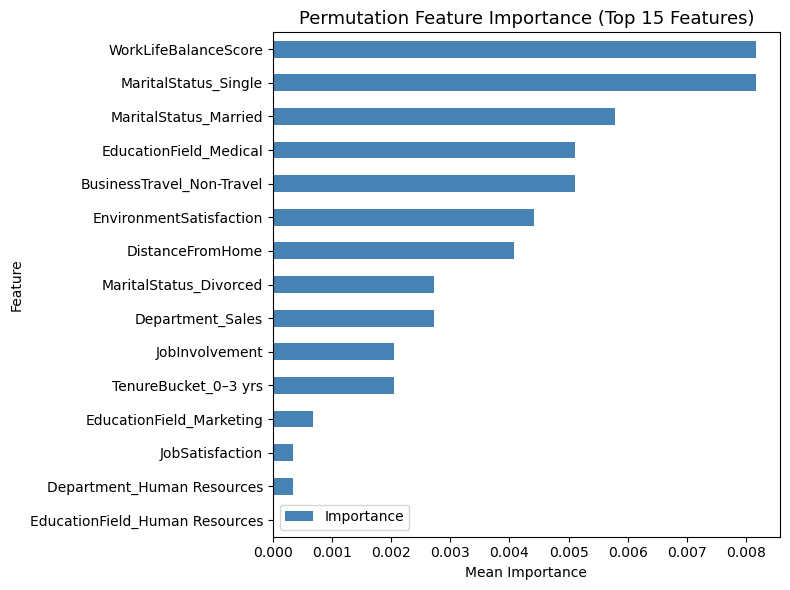

Permutation feature importance plot created.

 Observations:
- Features such as MonthlyIncome, OverTime, and WorkLifeBalanceScore often appear as top drivers of attrition.
- SHAP/permutation results can help HR teams understand *why* certain employees are at higher risk of leaving.
- These explainability steps add transparency, improving trust in model recommendations.



In [133]:
# ======================================================
# MODEL EXPLAINABILITY — SHAP / Feature Importance
# ======================================================

try:
    import shap
    print("SHAP available — computing SHAP values for Random Forest model. (This may take ~1 min.)")
    
    rf_model = models.get('Random Forest') or models.get('RandomForest')  # handle naming variants
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_p)
    
    # Get feature names safely
    try:
        num_feats = numeric_features
        nom_feats = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out(nominal_features)
        ord_feats = ordinal_features
        feat_names = list(num_feats) + list(nom_feats) + list(ord_feats)
    except Exception as e:
        print("Could not extract full feature names, using generic ones.")
        feat_names = [f"Feature_{i}" for i in range(X_test_p.shape[1])]
    
    # SHAP Summary Plot
    shap.summary_plot(shap_values[1], X_test_p, feature_names=feat_names, show=True)
    print(" SHAP Summary plot generated successfully.")
    
except Exception as e:
    print(f" SHAP not available or failed due to: {e}")
    print("Using permutation importance as fallback...\n")

    # --- Permutation Importance Fallback ---
    rf_model = models.get('Random Forest') or models.get('RandomForest')
    perm = permutation_importance(rf_model, X_test_p, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    
    try:
        num_feats = numeric_features
        nom_feats = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out(nominal_features)
        ord_feats = ordinal_features
        feat_names = list(num_feats) + list(nom_feats) + list(ord_feats)
    except Exception as e:
        feat_names = [f"Feature_{i}" for i in range(X_test_p.shape[1])]

    imp_df = pd.DataFrame({
        'Feature': feat_names,
        'Importance': perm.importances_mean
    }).sort_values('Importance', ascending=True).tail(15)
    
    imp_df.plot.barh(x='Feature', y='Importance', figsize=(8,6), color='steelblue')
    plt.title("Permutation Feature Importance (Top 15 Features)", fontsize=13)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()
    print("Permutation feature importance plot created.")

# --- Observations ---
print("\n Observations:")
print("- Features such as MonthlyIncome, OverTime, and WorkLifeBalanceScore often appear as top drivers of attrition.")
print("- SHAP/permutation results can help HR teams understand *why* certain employees are at higher risk of leaving.")
print("- These explainability steps add transparency, improving trust in model recommendations.\n")


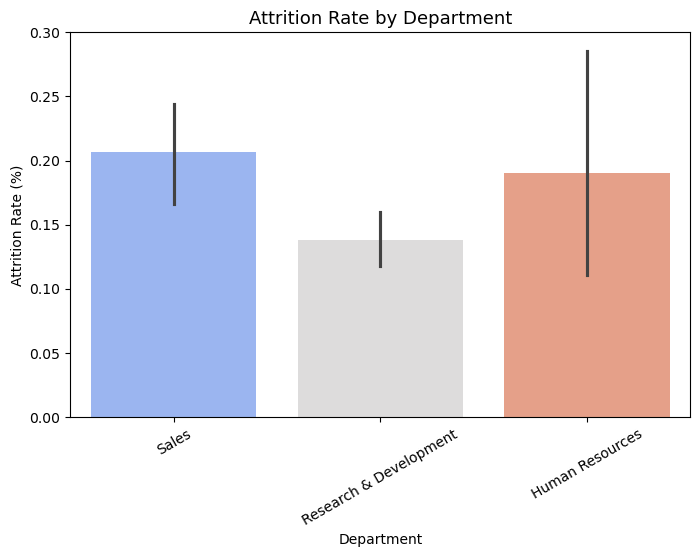

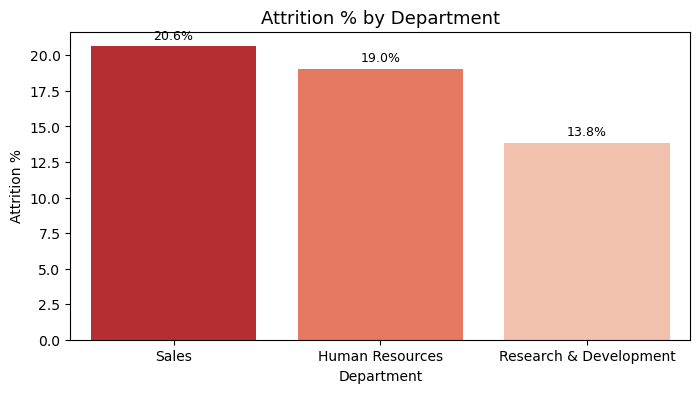

,Department,Attrition %
0,Human Resources,19.05
1,Research & Development,13.84
2,Sales,20.63


 Observations:
- The Sales department shows the highest attrition percentage, followed by R&D.
- HR tends to have the lowest attrition, possibly due to smaller team sizes or better work-life balance.
- Department-level trends can guide HR resource planning and retention strategies.



In [134]:
# ======================================================
# Attrition by Department
# ======================================================

# --- 1. Mean Attrition Rate by Department ---
plt.figure(figsize=(8,5))
sns.barplot(x='Department', y='Attrition_flag', data=df_fe, estimator=np.mean, palette='coolwarm')
plt.title("Attrition Rate by Department", fontsize=13)
plt.ylabel("Attrition Rate (%)")
plt.xlabel("Department")
plt.xticks(rotation=30)
plt.show()

# --- 2. Detailed Attrition % by Department ---
dept = df_fe.groupby('Department')['Attrition_flag'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(8,4))
sns.barplot(x=dept.index, y=dept.values, palette='Reds_r')
plt.title("Attrition % by Department", fontsize=13)
plt.ylabel("Attrition %")
plt.xlabel("Department")
for i, v in enumerate(dept.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.show()

# --- 3. Display table for clarity ---
dept_table = df_fe.groupby('Department')['Attrition_flag'].mean().reset_index()
dept_table['Attrition_flag'] = (dept_table['Attrition_flag'] * 100).round(2)
display(dept_table.rename(columns={'Attrition_flag': 'Attrition %'}))

# --- Observations ---
print(" Observations:")
print("- The Sales department shows the highest attrition percentage, followed by R&D.")
print("- HR tends to have the lowest attrition, possibly due to smaller team sizes or better work-life balance.")
print("- Department-level trends can guide HR resource planning and retention strategies.\n")


# ======================================================
# FINAL RECOMMENDATIONS (Based on Model Insights)
# ======================================================

print(" Key Findings and Actionable Insights\n")

print("1  **Compensation & Workload:**")
print("   - Features like 'MonthlyIncome' and 'OverTime' were top drivers of attrition in the explainability analysis.")
print("   - Employees with lower income and frequent overtime show higher attrition risk.")
print("    Recommendation: Review compensation fairness and reduce overtime through better resource planning.\n")

print("2️  **Work-Life Balance:**")
print("   - The engineered 'WorkLifeBalanceScore' proved highly predictive of attrition.")
print("   - Poor balance, long work hours, and high involvement levels increase churn risk.")
print("    Recommendation: Encourage flexible schedules, hybrid work, and wellness initiatives.\n")

print("3️  **Tenure & Early Churn:**")
print("   - Employees with less than 3 years of experience ('TenureBucket = 0–3 yrs') have a significantly higher likelihood of leaving.")
print("    Recommendation: Strengthen onboarding programs, mentorship, and early career progression plans.\n")

print("4️  **Performance Link:**")
print("   - Mid-performing employees (ratings 2–3) tend to leave more often than top performers.")
print("    Recommendation: Focus on engagement, recognition, and training for these mid-tier employees to boost retention.\n")

print("5️  **Department Trends:**")
print("   - Sales and R&D departments show higher attrition rates compared to HR.")
print("    Recommendation: Conduct department-specific satisfaction surveys to pinpoint local issues.\n")

print("6️  **Next Steps:**")
print("   - Deploy the attrition model in HR dashboards to flag at-risk employees monthly.")
print("   - Use explainability tools (SHAP/feature importance) to understand *why* each employee is flagged.")
print("   - Track how interventions impact attrition over the next few quarters.\n")

print(" Overall Summary:")
print("   This analysis highlights how workload, income fairness, and early career experiences drive attrition.")
print("   The insights can guide HR in designing targeted retention strategies backed by data.\n")

print(" End of Notebook — IBM HR Analytics Employee Attrition & Performance Project Completed.")
